In [41]:
from datetime import datetime, timedelta
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
datelist = pd.date_range(datetime.today(), periods=100).tolist()
from time import sleep
import dask.dataframe as dd
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import os
import glob
from datetime import date

from uuid import uuid4


from shapely.geometry import Polygon, MultiPolygon, LineString, GeometryCollection
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import geopandas as gpd
import seaborn as sns

import dask.dataframe as dd
import geopandas as gpd
from detect_heatwaves import detect
from datetime import timedelta
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt



In [42]:
full_df = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/THI/united_states/daily_max_THI.csv')

full_df.rename(columns={'time': 'datetime'}, inplace=True)
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
full_df['day'] = pd.DatetimeIndex(full_df['datetime']).day
full_df['month'] = pd.DatetimeIndex(full_df['datetime']).month
full_df['year'] = pd.DatetimeIndex(full_df['datetime']).year
full_df = full_df[~full_df['month'].isin([4, 10])]
full_df['location'] = full_df['adm2'] + ', ' + full_df['adm1']
full_df['datetime_ord'] = [date(x,y,z).toordinal() for x,y,z in zip(full_df['year'], full_df['month'], full_df['day'])]


## Find heat waves, heat wave lengths and assign unique heatwave IDs

In [44]:
full_df['datetime'].min()

'2018-05-01'

In [45]:
full_df['datetime'].min()

'2018-05-01'

In [46]:
full_df

,Unnamed: 0,datetime,latitude,longitude,t2m,d2m,rh,thi,adm2,adm1,day,month,year,location,datetime_ord
2,2,2018-05-01,48.823,-94.924529,5.084765,2.611386,96.578750,4.252362,Lake of the Woods,Minnesota,1,5,2018,"Lake of the Woods, Minnesota",736815
3,3,2018-05-02,48.823,-94.924529,14.119080,5.223062,89.900240,12.697205,Lake of the Woods,Minnesota,2,5,2018,"Lake of the Woods, Minnesota",736816
4,4,2018-05-03,48.823,-94.924529,16.279842,6.429565,96.589165,14.973853,Lake of the Woods,Minnesota,3,5,2018,"Lake of the Woods, Minnesota",736817
5,5,2018-05-04,48.823,-94.924529,16.552347,3.995145,75.901110,15.247277,Lake of the Woods,Minnesota,4,5,2018,"Lake of the Woods, Minnesota",736818
6,6,2018-05-05,48.823,-94.924529,16.544933,4.557828,77.760605,15.407652,Lake of the Woods,Minnesota,5,5,2018,"Lake of the Woods, Minnesota",736819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440558,2440558,2022-09-26,39.973,-105.074681,25.219244,7.099616,86.648224,24.379853,Broomfield,Colorado,26,9,2022,"Broomfield, Colorado",738424
2440559,2440559,2022-09-27,39.973,-105.074681,22.750202,9.785602,79.907364,21.860018,Broomfield,Colorado,27,9,2022,"Broomfield, Colorado",738425
2440560,2440560,2022-09-28,39.973,-105.074681,26.885015,9.104401,88.369340,25.782324,Broomfield,Colorado,28,9,2022,"Broomfield, Colorado",738426
2440561,2440561,2022-09-29,39.973,-105.074681,26.810797,8.920611,68.995834,25.815505,Broomfield,Colorado,29,9,2022,"Broomfield, Colorado",738427


In [47]:
full_df['pct'] = full_df.groupby('location')['thi'].transform(lambda x: x.rank(pct=True))

In [48]:
#create dictionary containing each county's heatwave periods
heatwave_dic = {}
for adm2 in full_df['location'].unique():
    adm2_df = full_df[(full_df['location'] == adm2)]
    adm2_df.reset_index(inplace=True)
    adm2_df = adm2_df.sort_values(by='datetime')
    adm2_df.drop_duplicates(['adm2', 'datetime'], inplace=True)
    heatwave_dic[adm2] = detect(adm2_df['datetime_ord'].values, adm2_df['thi'].values, pctile=90, minDuration=2)

    
heatwave_dates = {}
consec_dates = {}
heatwave_IDs = {}
for adm2 in heatwave_dic.keys(): 
    consec_dates[adm2] = {}
    heatwave_dates[adm2] = []
    heatwave_IDs[adm2] = {}


    heatwave_starts = heatwave_dic[adm2]['date_start']
    heatwave_ends = heatwave_dic[adm2]['date_end']
    for i in range(len(heatwave_starts)):
        heatwave_code = str(uuid4())
        heatwave_days = pd.date_range(heatwave_starts[i],heatwave_ends[i],freq='d')
        length_heatwaves = len(heatwave_days)
        consec_dates[adm2][heatwave_days[0]] = length_heatwaves
        for item in heatwave_days:
            heatwave_dates[adm2].append(item)
            heatwave_IDs[adm2][item] = heatwave_code
            
            
heat_df = pd.DataFrame.from_dict(heatwave_dates, orient='index').unstack().reset_index()
heat_df.rename(columns={'level_1':'location', 0:'datetime'}, inplace=True)


heat_df.dropna(inplace=True)
heat_df['heatwave']=1

In [52]:
full_df

,Unnamed: 0,datetime,latitude,longitude,t2m,d2m,rh,thi,adm2,adm1,day,month,year,location,datetime_ord,pct
2,2,2018-05-01,48.823,-94.924529,5.084765,2.611386,96.578750,4.252362,Lake of the Woods,Minnesota,1,5,2018,"Lake of the Woods, Minnesota",736815,0.006536
3,3,2018-05-02,48.823,-94.924529,14.119080,5.223062,89.900240,12.697205,Lake of the Woods,Minnesota,2,5,2018,"Lake of the Woods, Minnesota",736816,0.120261
4,4,2018-05-03,48.823,-94.924529,16.279842,6.429565,96.589165,14.973853,Lake of the Woods,Minnesota,3,5,2018,"Lake of the Woods, Minnesota",736817,0.190850
5,5,2018-05-04,48.823,-94.924529,16.552347,3.995145,75.901110,15.247277,Lake of the Woods,Minnesota,4,5,2018,"Lake of the Woods, Minnesota",736818,0.200000
6,6,2018-05-05,48.823,-94.924529,16.544933,4.557828,77.760605,15.407652,Lake of the Woods,Minnesota,5,5,2018,"Lake of the Woods, Minnesota",736819,0.205229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440558,2440558,2022-09-26,39.973,-105.074681,25.219244,7.099616,86.648224,24.379853,Broomfield,Colorado,26,9,2022,"Broomfield, Colorado",738424,0.316340
2440559,2440559,2022-09-27,39.973,-105.074681,22.750202,9.785602,79.907364,21.860018,Broomfield,Colorado,27,9,2022,"Broomfield, Colorado",738425,0.211765
2440560,2440560,2022-09-28,39.973,-105.074681,26.885015,9.104401,88.369340,25.782324,Broomfield,Colorado,28,9,2022,"Broomfield, Colorado",738426,0.396078
2440561,2440561,2022-09-29,39.973,-105.074681,26.810797,8.920611,68.995834,25.815505,Broomfield,Colorado,29,9,2022,"Broomfield, Colorado",738427,0.400000


In [56]:
full_df['datetime'] = pd.to_datetime(full_df['datetime'])

In [57]:
full_df = full_df.merge(heat_df, on=['location', 'datetime'], how='left')

full_df['heatwave'] = full_df['heatwave'].replace(np.nan, 0)

In [88]:
full_2022

,Unnamed: 0,datetime,latitude,longitude,t2m,d2m,rh,thi,adm2,adm1,day,month,year,location,datetime_ord,pct,level_0,heatwave,heat_ID,Heat Wave Duration
53,679,2022-06-19,48.823,-94.924529,29.951385,21.954230,79.266950,33.701498,Lake of the Woods,Minnesota,19,6,2022,"Lake of the Woods, Minnesota",738325,0.994771,53.0,1.0,63c76922-7346-4379-a835-658676278125,2.0
54,680,2022-06-20,48.823,-94.924529,30.121433,22.171420,97.089294,32.277237,Lake of the Woods,Minnesota,20,6,2022,"Lake of the Woods, Minnesota",738326,0.990850,54.0,1.0,63c76922-7346-4379-a835-658676278125,NaN
55,707,2022-07-17,48.823,-94.924529,28.185480,22.272985,96.181980,30.462246,Lake of the Woods,Minnesota,17,7,2022,"Lake of the Woods, Minnesota",738353,0.969935,55.0,1.0,c18931ca-3efd-4298-96ed-7fdb47d79996,3.0
56,708,2022-07-18,48.823,-94.924529,28.462570,23.155182,98.039230,31.073392,Lake of the Woods,Minnesota,18,7,2022,"Lake of the Woods, Minnesota",738354,0.979085,56.0,1.0,c18931ca-3efd-4298-96ed-7fdb47d79996,NaN
57,709,2022-07-19,48.823,-94.924529,27.639002,22.091724,93.748510,29.287736,Lake of the Woods,Minnesota,19,7,2022,"Lake of the Woods, Minnesota",738355,0.941176,57.0,1.0,c18931ca-3efd-4298-96ed-7fdb47d79996,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184806,2440536,2022-09-04,39.973,-105.074681,32.709187,9.974713,72.566290,30.409554,Broomfield,Colorado,4,9,2022,"Broomfield, Colorado",738402,0.901961,54.0,1.0,25e6c35f-1db8-406f-a7d4-186a15e733dc,5.0
184807,2440537,2022-09-05,39.973,-105.074681,33.696440,10.817975,63.285057,31.246944,Broomfield,Colorado,5,9,2022,"Broomfield, Colorado",738403,0.956863,55.0,1.0,25e6c35f-1db8-406f-a7d4-186a15e733dc,NaN
184808,2440538,2022-09-06,39.973,-105.074681,34.503227,10.247663,62.555676,31.658971,Broomfield,Colorado,6,9,2022,"Broomfield, Colorado",738404,0.975163,56.0,1.0,25e6c35f-1db8-406f-a7d4-186a15e733dc,NaN
184809,2440539,2022-09-07,39.973,-105.074681,34.579450,9.090729,59.241310,31.583424,Broomfield,Colorado,7,9,2022,"Broomfield, Colorado",738405,0.971242,57.0,1.0,25e6c35f-1db8-406f-a7d4-186a15e733dc,NaN


In [59]:
full_df[full_df['heatwave'] == 1]['pct'].min()

0.9006535947712418

In [60]:
len(full_df[full_df['heatwave'] == 1]['location'].unique())

3107

In [61]:
codes = pd.DataFrame.from_dict(heatwave_IDs, orient='index').unstack().reset_index()

In [62]:
codes.columns=['datetime', 'location', 'heat_ID']

In [63]:
codes.dropna(inplace=True)

In [64]:
codes

,datetime,location,heat_ID
0,2018-07-07,"Lake of the Woods, Minnesota",04327ff6-dd28-4b6d-a96e-01a7b86bd323
1,2018-07-07,"Renville, North Dakota",ffd6c811-363a-4da8-b986-faae41b30bfa
2,2018-07-07,"Bottineau, North Dakota",fff42b1b-172f-4317-bb46-a1ecee44d39c
3,2018-07-07,"Kittson, Minnesota",59f85922-f7fa-4235-9030-68318b83382f
4,2018-07-07,"Roseau, Minnesota",a986786c-3b11-489f-a574-09a3bdbf13fa
...,...,...,...
1743307,2022-05-31,"Otsego, Michigan",438e5373-bcbe-492a-85c4-1cb390379423
1743308,2022-05-31,"Montmorency, Michigan",6ed724cc-e829-4452-bc64-51acec1bd4ee
1743309,2022-05-31,"Crawford, Michigan",1aec5ef2-098b-4cb6-9bd4-d5f5e5457fcc
1743311,2022-05-31,"Oscoda, Michigan",cb765c59-e15e-44b6-88e6-8b8dec0487f3


In [65]:
consec = pd.DataFrame.from_dict(consec_dates, orient='index').unstack().reset_index()

In [66]:
consec.columns= ['datetime', 'location', 'Heat Wave Duration']

In [67]:
consec['Heat Wave Duration'].max()

16.0

In [68]:
consec.dropna(inplace=True)

In [69]:
consec

,datetime,location,Heat Wave Duration
0,2018-07-07,"Lake of the Woods, Minnesota",2.0
1,2018-07-07,"Kittson, Minnesota",2.0
2,2018-07-07,"Roseau, Minnesota",2.0
3,2018-07-07,"Koochiching, Minnesota",2.0
4,2018-07-07,"St. Louis, Minnesota",2.0
...,...,...,...
1621810,2022-05-30,"Cheboygan, Michigan",2.0
1621811,2022-05-30,"Otsego, Michigan",2.0
1621812,2022-05-30,"Montmorency, Michigan",2.0
1621813,2022-05-30,"Crawford, Michigan",2.0


In [70]:
full_df = full_df.merge(codes, on=['datetime', 'location'])

In [71]:
full_df = full_df.merge(consec, on=['datetime', 'location'], how='left')

In [72]:
full_2022 = full_df[full_df['year'] == 2022]

In [73]:
full_df['heat_ID'].value_counts()

288f6358-c876-48ae-9a57-a67807206bb3    16
ed645f78-bf3a-4cf2-a853-46e3bb2de9a0    16
efdaa011-22b3-4571-9342-f8e6cfad4745    15
3825557d-66ee-40ee-872e-fa0370112794    15
e7dd90c4-8846-4102-a7bd-aa54c4d420be    15
                                        ..
1d1fc4a5-6416-49e9-a26f-4197cdb1882b     2
df623519-536e-496b-858c-bdbe37a3428d     2
d8c307df-c31e-4176-9c6c-9f968d40105f     2
62ba3536-5d78-4030-b43b-a672a87c3530     2
651aef0e-d186-4887-b09f-428d0f5b4df0     2
Name: heat_ID, Length: 57978, dtype: int64

In [74]:
gdf = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/adm0_shp/united_states/clean_shp.shp')

In [79]:
for_plot = gdf.merge(full_df.groupby(['adm2', 'adm1'])['thi'].mean().reset_index(), left_on=['adm2', 'adm1'], right_on=['adm2', 'adm1'])

Text(0.5, 1.0, 'United States 2022 heatwave temperatures (THI)')

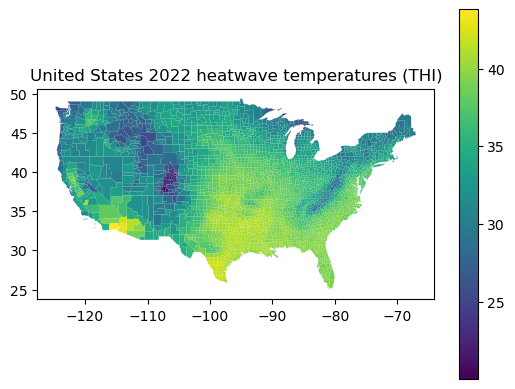

In [89]:
for_plot.plot(column='thi', legend=True)
plt.title("United States 2022 heatwave temperatures (THI)")

In [81]:
#changed from v2
full_2022.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/united_states/THI_united_states_90_2022.csv')
full_df.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/united_states/THI_united_states_90_2018_2022.csv')